# Recommender Models

By Karl Heyer

In this project we're going to build a recommender system based on the [Movielens Data Set](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip). The Movielens data contains approximately 100,000 user movie reviews rating a given movie 0.5-5. The recommender model will generate movie recommendations for a user based on their past movie ratings.

# Contents
1. Model Architecture
2. Data Analysis
3. Model Setup
4. Model Exploration
    * 4.1 Basic Embedding Scaled
    * 4.2 Mini Net
    * 4.3 Net with Bias
5. Building a Recommender
6. Model Interpretations
7. User Recommendations
8. New User Onboarding
9. Generic User Model
10. Conclusions

# 1. Model Architecture
In this project we are going to build a recommender system based on matrix factorization. Then we will explore other architectures that can build off this approach.

## Recommender Systems
A recommender system is an information filtering system that tries to predict a user's rating for some item. In this case our item will be a movie. The recommender system uses user rating data to learn the complex relationship between different users and different products. Recommender systems basically ask the following questions:

For a given user, what items do they like? What items do they dislike?

For a given item, what users liked the item the most? What users disliked the item the most?

What users are similar based on their item ratings?

What items are similar, based on the users who liked them?

All the interplay of user preferences are rolled into the recommender system. So how will we build one?

## Recommender Systems by Matrix Factorization

Matrix factorization approaches to recommender systems gained attention in 2009 when the matrix factorization technique was used successfully in the 2009 Netflix prize. More details on this can be found [here](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf).

The gist of the approach is as follows:

Imagine all the user and item information presented as a crosstabulated matrix, where each value $a_{ user_{i}, item_{j}}$ in the matrix is the rating user i gave to item j. This crosstabulated matrix could be factored into two matrices - a user matrix and an item matrix such that $M_{users} M_{items} = M_{crosstab}$

[](attachment:im1.png)

<img src="im1.png">

There's a problem with this though. Any real user/item matrix will be extremely sparse. No user has reviewed every movie. The bulk of users have only reviewed a handful of movies. How do you deal with all the missing values? Any strategy based on filling in missing values with a placeholder or an average will only serve to skew the results of the model. Because of this, any analytical approach to matrix factorization will fail.

The solution is to use a machine learing approach to develop the user matrix and the item matrix using only the data available. With this approach, user data and item data are put into embedding matrices, where each user or item is represented by a row in the matrix.

[](attachment:im2.png)

<img src="im2.png">

Each user/item has a unique set of weights describing the item. Based on the matrix factorization approach, we expect the dot product between the weights for a given user and the weights for a given item will give the user rating for that item.

[](attachment:im3.png)

<img src="im3.png">

This allows you to develop a model using only the paired (user, item) -> rating data that exists in the data set. The goal of the recommender model will be to learn the weights that best represent each user and each item. The hope of using this approach is that the user and item weights the model learns will generalize beyond the training data. The model will then be able to estimate a user's rating for a new item by taking the dot product of the user weights and the item weights. The model can generate recommendations of new items for a user by finding the user dot item combo that yields the highest predicted rating.

# 2. Data Analysis

This project will use fast.ai, pytorch, and the dependencies of these libraries.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

In [2]:
#Set GPU
torch.cuda.set_device(1)
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.enabled

True

In [4]:
path='data/ml-latest-small/'

The ratings data spreadsheet has paired (user, movie, rating) data for 100,004 user movie reviews. The data set covers 9066 unique movies and 671 unique users.

In [5]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
len(ratings)

100004

In [7]:
len(ratings.movieId.unique())

9066

In [8]:
len(ratings.userId.unique())

671

In [9]:
ratings.movieId.max()

163949

We can also connect movie Ids to movie titles.

In [10]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

This is the sort of crosstabbed matrix we want the model to produce.

In [12]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


# 3. Model Setup

To start, we need to prepare a dataloader. To do this easily, we will use a CollabFilterDataset object from fast.ai. This creates a Pytorch dataloader that will feed (user, item, rating) data to the model. It also does some useful data processing behind the scenes. 

Within the CollabFilterDataset object, each user Id and movie Id is mapped to a unique index. This ensures large index values don't blow up our embedding matrix. For example, the largest movie Id in the data set is 163949, but there are only 9066 movies represented. If we didn't map the Ids, our embedding matrix would have to have 163949 rows, which would be absurd.

The dataloader also extracts the number of users, number of items, the min rating score and the max rating score.

In [13]:
val_idxs = get_cv_idxs(len(ratings))
cf = CollabFilterDataset.from_data_frame(path, ratings, 'userId', 'movieId', 'rating')

## Collaborative Filtering - Basic Embedding Bias Model

The first model we'll train comes directly from fast.ai. It's the exact dot product model described above, only with the added tweak of bias terms for users and movies. This allows the model to account for things like some users giving generally higher ratings than others, or some movies being generally more popular than others.

The model also has an interesting way of generating the final output, given by 

$F.sigmoid(x) * (max score - min score) + min score$

The logic behind this is that sure, you could avoid any final activation and let your model learn that the output ratings should be between 0.5 and 5. But this is just another parameter that the model has to figure out on top of everything else. And you can run into weird situations where the model outputs values slightly outside the 0.5 - 5 range.

The solution to this is to squash the output with a sigmoid and scale it between the min and max ratings. This is just taking advantage of domain knowledge that tells us the final output must be between these values. This makes training the model easier. Now the model only needs to output a big number when a user likes an item and a small number when a user doesn't.

In [14]:
#From fast.ai source 
class EmbeddingDotBias(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users, items):
        um = self.u(users)* self.i(items)
        res = um.sum(1) + self.ub(users).squeeze() + self.ib(items).squeeze()
        res = F.sigmoid(res) * (self.max_score-self.min_score) + self.min_score
        return res

In [15]:
wd=2e-4
n_factors = 50
n_users = cf.n_users
n_items = cf.n_items
max_rating = cf.max_score
min_rating = cf.min_score

In [16]:
model = EmbeddingDotBias(n_factors, n_users, n_items, min_rating, max_rating).cuda()

In [17]:
learner = CollabFilterLearner(cf.get_data(val_idxs, 128), CollabFilterModel(model), opt_fn=optim.Adam)

In [18]:
learner.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.821621   0.826325  
    1      0.759099   0.774451                                                                                         
    2      0.605246   0.759806                                                                                         
    3      0.795292   0.781049                                                                                         
    4      0.630582   0.763085                                                                                         
    5      0.524155   0.758346                                                                                         
    6      0.394643   0.759017                                                                                         



[0.7590165189743042]

So this model got to about 0.76 validation loss before it started badly overfitting. We will use this as a benchmark for looking at other model variants.

# 4. Model Exploration

I wanted to try some variants on the embedding with bias model shown above.

## 4.1 Basic Embedding Scaled

The first thing I wanted to try was seeing if getting rid of the rating scaling would do anything for performance. I normalized the ratings between 0 and 1 and removed the rating scaling after the sigmoid.

In [19]:
from sklearn import preprocessing

rating_vals = ratings.rating.values.reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
ratings_scaled = min_max_scaler.fit_transform(rating_vals)

In [20]:
df_scaled = ratings.copy()
df_scaled['ratings_scaled'] = ratings_scaled

In [21]:
df_scaled.head()

,userId,movieId,rating,timestamp,ratings_scaled
0,1,31,2.5,1260759144,0.444444
1,1,1029,3.0,1260759179,0.555556
2,1,1061,3.0,1260759182,0.555556
3,1,1129,2.0,1260759185,0.333333
4,1,1172,4.0,1260759205,0.777778


In [22]:
df_scaled.ratings_scaled.min(), df_scaled.ratings_scaled.max()

(0.0, 1.0)

In [23]:
cf2 = CollabFilterDataset.from_data_frame(path, df_scaled, 'userId', 'movieId', 'ratings_scaled')

In [24]:
class EmbeddingDotBias2(nn.Module):
    def __init__(self, n_factors, n_users, n_items):
        super().__init__()
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users, items):
        um = self.u(users)* self.i(items)
        res = um.sum(1) + self.ub(users).squeeze() + self.ib(items).squeeze()
        res = F.sigmoid(res)
        return res

In [25]:
wd=2e-4
n_factors = 50
n_users = cf.n_users
n_items = cf.n_items

In [26]:
model = EmbeddingDotBias2(n_factors, n_users, n_items).cuda()

In [27]:
learner = CollabFilterLearner(cf2.get_data(val_idxs, 128), CollabFilterModel(model), opt_fn=optim.Adam)

In [28]:
learner.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.051038   0.052178  
    1      0.051653   0.051202                                                                                         
    2      0.050066   0.051058                                                                                         



[0.05105783131122589]

In [29]:
learner.fit(5e-3, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.051612   0.051238  
    1      0.052044   0.051045                                                                                         
    2      0.049404   0.051079                                                                                         
    3      0.05166    0.05111                                                                                          
    4      0.049405   0.051078                                                                                         
    5      0.049135   0.051086                                                                                         
    6      0.049752   0.051087                                                                                         



[0.05108709952831268]

On the surface our loss looks much better, but this could be entirely due to the rescaling. Before, predicting 5 against 0.5 would earn a loss of 20.25 (mse). Doing the equivalent here, predicting 1 against 0, would only earn a loss of 1.

To compare model performance, we need to use the min max scaler to inverse transform the predictions and the actuals and see what the loss looks like on the 5 point scale.

In [30]:
preds, y = learner.predict_with_targs()

In [31]:
preds

array([0.5027 , 0.65452, 0.55099, ..., 0.63517, 0.59037, 0.60547], dtype=float32)

In [32]:
y

array([0.66667, 0.77778, 0.55556, ..., 0.77778, 0.77778, 0.66667], dtype=float32)

In [33]:
preds = min_max_scaler.inverse_transform(preds.reshape(-1, 1))
preds

array([[2.76217],
       [3.44532],
       [2.97947],
       ...,
       [3.35828],
       [3.15666],
       [3.2246 ]], dtype=float32)

In [34]:
y = min_max_scaler.inverse_transform(y.reshape(-1, 1))
y

array([[3.5],
       [4. ],
       [3. ],
       ...,
       [4. ],
       [4. ],
       [3.5]], dtype=float32)

In [35]:
scaled_loss = ((y - preds)**2).mean()
scaled_loss

1.0345137

The scaled loss is 1.03. This is much worse than our baseline loss of 0.76! No improvement here.

## 4.2 Mini Net

With this variant, we still start off with the embedding matrices for users and items. However instead of calculating a dot product and adding bias, we concatenate the user and move weights and feed them through two dense layers.

In [36]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_factors, n_users, n_items, nh, min_score, max_score, drops):
        super().__init__()
        (self.u, self.i) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors)]]
        
        self.max_score = max_score
        self.min_score = min_score
        
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        
        self.drop1 = nn.Dropout(drops[0])
        self.drop2 = nn.Dropout(drops[1])

    def forward(self, users, items):
        x = self.drop1(torch.cat([self.u(users), self.i(items)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        x = F.sigmoid(self.lin2(x)) * (self.max_score-self.min_score) + self.min_score
        return x.squeeze()

In [37]:
n_users = cf.n_users
n_items = cf.n_items
n_factors = 50
nh = 16
max_rating = cf.max_score
min_rating = cf.min_score
wd = 2e-4
drops = [0.05, 0.1]

In [38]:
model = EmbeddingNet(n_factors, n_users, n_items, nh, min_rating, max_rating, drops).cuda()

In [39]:
learn_test = CollabFilterLearner(cf.get_data(val_idxs, 128), CollabFilterModel(model), opt_fn=optim.Adam)

In [40]:
learn_test.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.809743   0.800732  
    1      0.853515   0.803639                                                                                         
    2      0.731731   0.778439                                                                                         
    3      0.81282    0.797001                                                                                         
    4      0.777618   0.783927                                                                                         
    5      0.715608   0.772345                                                                                         
    6      0.699388   0.775068                                                                                         



[0.7750678997039795]

A validation loss of about 0.77 was the best I could get after playing around with layer size and dropout. Maybe a deeper network will help?

Here's the same model with a third linear layer.

In [41]:
class EmbeddingNet2(nn.Module):
    def __init__(self, n_factors, n_users, n_items, nh, min_score, max_score, drops):
        super().__init__()
        (self.u, self.i) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors)]]
        
        self.max_score = max_score
        self.min_score = min_score
        
        self.lin1 = nn.Linear(n_factors*2, nh[0])
        self.lin2 = nn.Linear(nh[0], nh[1])
        self.lin3 = nn.Linear(nh[1], 1)
        
        self.drop1 = nn.Dropout(drops[0])
        self.drop2 = nn.Dropout(drops[1])
        self.drop3 = nn.Dropout(drops[2])

    def forward(self, users, items):
        x = self.drop1(torch.cat([self.u(users), self.i(items)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        x = self.drop3(F.relu(self.lin2(x)))
        x = F.sigmoid(self.lin3(x)) * (self.max_score-self.min_score) + self.min_score
        return x.squeeze()

In [42]:
n_users = cf.n_users
n_items = cf.n_items
n_factors = 50
nh = [32, 16]
max_rating = cf.max_score
min_rating = cf.min_score
wd = 2e-4
drops = [0.05, 0.1, 0.2]

In [43]:
model = EmbeddingNet2(n_factors, n_users, n_items, nh, min_rating, max_rating, drops).cuda()

In [44]:
learn_test = CollabFilterLearner(cf.get_data(val_idxs, 128), CollabFilterModel(model), opt_fn=optim.Adam)

In [45]:
learn_test.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.845502   0.825246  
    1      0.882795   0.824288                                                                                         
    2      0.791897   0.799933                                                                                         
    3      0.825633   0.825779                                                                                         
    4      0.843486   0.807988                                                                                         
    5      0.815732   0.792831                                                                                         
    6      0.74085    0.792876                                                                                         



[0.7928760189056396]

In [46]:
learn_test.fit(1e-3, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.754963   0.788918  
    1      0.733867   0.78134                                                                                          
    2      0.693705   0.782629                                                                                         
    3      0.715444   0.778848                                                                                         
    4      0.695345   0.781711                                                                                         
    5      0.655097   0.786722                                                                                         
    6      0.602179   0.790694                                                                                         



[0.7906940210342407]

The deeper network performs slightly worse.

## 4.3 Net with Bias

I'm thinking that maybe the bias terms in the original embedding model were important to helping performance. It gave the model a way to scale outputs on a per user or per item basis. The above models with dense layers do have bias terms, but these are applied to any input that moves through the layer and are not unique to movies/users.

I want to try adding the bias terms back in. I'm not sure where would be the best place to put them so I'm going to try a few things.

First I'm going to add the user/item bias directly to the user/item weights. I don't expect this to do anything since it's just a linear scaling of the user/item weights, but I want to cover my bases.

In [47]:
class EmbeddingBiasNet(nn.Module):
    def __init__(self, n_factors, n_users, n_items, nh, min_score, max_score, drops):
        super().__init__()
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]
        
        self.max_score = max_score
        self.min_score = min_score
        
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        
        self.drop1 = nn.Dropout(drops[0])
        self.drop2 = nn.Dropout(drops[1])

    def forward(self, users, items):
        u = self.u(users) + self.ub(users)
        i = self.i(items) + self.ib(items)
        x = self.drop1(torch.cat([u, i], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        x = F.sigmoid(self.lin2(x)) * (self.max_score-self.min_score) + self.min_score
        return x.squeeze()

In [48]:
n_users = cf.n_users
n_items = cf.n_items
n_factors = 50
nh = 16
max_rating = cf.max_score
min_rating = cf.min_score
wd = 2e-4
drops = [0.05, 0.1]

In [49]:
model = EmbeddingBiasNet(n_factors, n_users, n_items, nh, min_rating, max_rating, drops).cuda()

In [50]:
learn_test = CollabFilterLearner(cf.get_data(val_idxs, 128), CollabFilterModel(model), opt_fn=optim.Adam)

In [51]:
learn_test.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.80807    0.798446  
    1      0.830046   0.80216                                                                                          
    2      0.749354   0.780163                                                                                         
    3      0.837584   0.817445                                                                                         
    4      0.761536   0.797043                                                                                         
    5      0.747977   0.770586                                                                                         
    6      0.682848   0.774333                                                                                         



[0.7743334857940674]

In [52]:
learn_test.fit(1e-3, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.720126   0.774356  
    1      0.698487   0.770633                                                                                         
    2      0.668      0.772337                                                                                         
    3      0.678204   0.772168                                                                                         
    4      0.736141   0.772623                                                                                         
    5      0.657451   0.776815                                                                                         
    6      0.602292   0.777814                                                                                         



[0.777813743686676]

No dice. Next step: add biases after concatenating the user and movie weights.

In [53]:
class EmbeddingBiasNet2(nn.Module):
    def __init__(self, n_factors, n_users, n_items, nh, min_score, max_score, drops):
        super().__init__()
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]
        
        self.max_score = max_score
        self.min_score = min_score
        
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        
        self.drop1 = nn.Dropout(drops[0])
        self.drop2 = nn.Dropout(drops[1])

    def forward(self, users, items):
        u = self.u(users)
        i = self.i(items)
        x = self.drop1(torch.cat([u, i], dim=1)) + self.ub(users) + self.ib(items)
        x = self.drop2(F.relu(self.lin1(x)))
        x = F.sigmoid(self.lin2(x)) * (self.max_score-self.min_score) + self.min_score
        return x.squeeze()

In [54]:
n_users = cf.n_users
n_items = cf.n_items
n_factors = 50
nh = 16
max_rating = cf.max_score
min_rating = cf.min_score
wd = 2e-4
drops = [0.05, 0.1]

In [55]:
model = EmbeddingBiasNet2(n_factors, n_users, n_items, nh, min_rating, max_rating, drops).cuda()

In [56]:
learn_test = CollabFilterLearner(cf.get_data(val_idxs, 128), CollabFilterModel(model), opt_fn=optim.Adam)

In [57]:
learn_test.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.810942   0.804153  
    1      0.776697   0.791605                                                                                         
    2      0.718641   0.7779                                                                                           
    3      0.761412   0.791966                                                                                         
    4      0.781184   0.787583                                                                                         
    5      0.682536   0.774761                                                                                         
    6      0.667366   0.780949                                                                                         



[0.7809490306854248]

In [58]:
learn_test.fit(1e-3, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.686624   0.779061  
    1      0.691407   0.779448                                                                                         
    2      0.656698   0.778561                                                                                         
    3      0.676186   0.777106                                                                                         
    4      0.683218   0.776128                                                                                         
    5      0.628431   0.780044                                                                                         
    6      0.642072   0.780145                                                                                         



[0.7801454284667969]

Even worse performance! Attempt 3: adding user/item bias after the first linear layer.

In [59]:
class EmbeddingBiasNet3(nn.Module):
    def __init__(self, n_factors, n_users, n_items, nh, min_score, max_score, drops):
        super().__init__()
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]
        
        self.max_score = max_score
        self.min_score = min_score
        
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        
        self.drop1 = nn.Dropout(drops[0])
        self.drop2 = nn.Dropout(drops[1])

    def forward(self, users, items):
        u = self.u(users)
        i = self.i(items)
        x = self.drop1(torch.cat([u, i], dim=1))
        x = self.drop2(F.relu(self.lin1(x))) + self.ub(users) + self.ib(items)
        x = F.sigmoid(self.lin2(x)) * (self.max_score-self.min_score) + self.min_score
        return x.squeeze()

In [60]:
n_users = cf.n_users
n_items = cf.n_items
n_factors = 50
nh = 16
max_rating = cf.max_score
min_rating = cf.min_score
wd = 2e-4
drops = [0.05, 0.1]

In [61]:
model = EmbeddingBiasNet3(n_factors, n_users, n_items, nh, min_rating, max_rating, drops).cuda()

In [62]:
learn_test = CollabFilterLearner(cf.get_data(val_idxs, 128), CollabFilterModel(model), opt_fn=optim.Adam)

In [63]:
learn_test.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.802186   0.799919  
    1      0.778246   0.790549                                                                                         
    2      0.727312   0.787008                                                                                         
    3      0.777118   0.793277                                                                                         
    4      0.761485   0.785425                                                                                         
    5      0.71779    0.782891                                                                                         
    6      0.662865   0.786951                                                                                         



[0.786950917339325]

In [64]:
learn_test.fit(1e-3, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.677118   0.786496  
    1      0.694053   0.785583                                                                                         
    2      0.667264   0.78692                                                                                          
    3      0.685221   0.787086                                                                                         
    4      0.678408   0.785696                                                                                         
    5      0.666666   0.786896                                                                                         
    6      0.674754   0.787514                                                                                         



[0.7875143158912659]

Nothing impressive here either. Final shot at this: adding bias after the second linear layer.

In [65]:
class EmbeddingBiasNet4(nn.Module):
    def __init__(self, n_factors, n_users, n_items, nh, min_score, max_score, drops):
        super().__init__()
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]
        
        self.max_score = max_score
        self.min_score = min_score
        
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        
        self.drop1 = nn.Dropout(drops[0])
        self.drop2 = nn.Dropout(drops[1])

    def forward(self, users, items):
        u = self.u(users)
        i = self.i(items)
        x = self.drop1(torch.cat([u, i], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        x = self.lin2(x) + self.ub(users) + self.ib(items)
        x = F.sigmoid(x) * (self.max_score-self.min_score) + self.min_score
        return x.squeeze()

In [66]:
n_users = cf.n_users
n_items = cf.n_items
n_factors = 50
nh = 16
max_rating = cf.max_score
min_rating = cf.min_score
wd = 2e-4
drops = [0.05, 0.1]

In [67]:
model = EmbeddingBiasNet4(n_factors, n_users, n_items, nh, min_rating, max_rating, drops).cuda()

In [68]:
learn_test = CollabFilterLearner(cf.get_data(val_idxs, 128), CollabFilterModel(model), opt_fn=optim.Adam)

In [69]:
learn_test.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.809579   0.794768  
    1      0.768189   0.79147                                                                                          
    2      0.719578   0.771486                                                                                         
    3      0.815243   0.784319                                                                                         
    4      0.803961   0.77761                                                                                          
    5      0.692715   0.765185                                                                                         
    6      0.67009    0.7668                                                                                           



[0.7667998189926147]

In [70]:
learn_test.fit(1e-3, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.704504   0.770321  
    1      0.692279   0.767486                                                                                         
    2      0.695225   0.768421                                                                                         
    3      0.679992   0.766714                                                                                         
    4      0.660288   0.768525                                                                                         
    5      0.630693   0.770525                                                                                         
    6      0.613039   0.770817                                                                                         



[0.7708167308807373]

Okay so here's something. We're finally seeing the validation loss drop below 0.77.

This is certainly comparable to the original model. The original model had a best run of (0.63, 0.763) train/validation loss. Here we never get the validation loss quite that low, but we do see the result of (0.692, 0.765) which is a comprable validation loss with less overfitting.

Lets try a few more things.

First, I want to try another way of adding user or item bias. We'll make separate linear layers for the users and items that user weights and item weights will go through before being concatenated.

In [71]:
class EmbeddingBiasNet5(nn.Module):
    def __init__(self, n_factors, n_users, n_items, hiddens, min_score, max_score, drops):
        super().__init__()
        (self.u, self.i) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors)
        ]]
        
        self.max_score = max_score
        self.min_score = min_score
        
        self.lin_u = nn.Linear(n_factors, hiddens[0])
        self.lin_i = nn.Linear(n_factors, hiddens[0])
        
        self.lin1 = nn.Linear(hiddens[0]*2, hiddens[1])
        self.lin2 = nn.Linear(hiddens[1], 1)
        
        self.drop1 = nn.Dropout(drops[0])
        self.drop2 = nn.Dropout(drops[1])
        self.drop3 = nn.Dropout(drops[2])

    def forward(self, users, items):
        u = self.drop1(self.lin_u(self.u(users)))
        i = self.drop1(self.lin_i(self.i(items)))

        x = self.drop2(torch.cat([u, i], dim=1))
        x = self.drop3(F.relu(self.lin1(x)))
        x = F.sigmoid(self.lin2(x)) * (self.max_score-self.min_score) + self.min_score
        return x.squeeze()

In [72]:
n_users = cf.n_users
n_items = cf.n_items
n_factors = 50
hiddens = [32,16]
max_rating = cf.max_score
min_rating = cf.min_score
wd = 2e-4
drops = [0.05, 0.1, 0.2]

In [73]:
model = EmbeddingBiasNet5(n_factors, n_users, n_items, hiddens, min_rating, max_rating, drops).cuda()

In [74]:
learn_test = CollabFilterLearner(cf.get_data(val_idxs, 128), CollabFilterModel(model), opt_fn=optim.Adam)

In [75]:
learn_test.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.808403   0.80877   
    1      0.820515   0.8037                                                                                           
    2      0.747208   0.777919                                                                                         
    3      0.817249   0.805672                                                                                         
    4      0.745424   0.787095                                                                                         
    5      0.728579   0.771786                                                                                         
    6      0.662271   0.775961                                                                                         



[0.775960604763031]

In [76]:
learn_test.fit(1e-3, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.730081   0.776629  
    1      0.691474   0.77406                                                                                          
    2      0.659446   0.775296                                                                                         
    3      0.687853   0.774215                                                                                         
    4      0.678926   0.775284                                                                                         
    5      0.666123   0.775907                                                                                         
    6      0.689211   0.777757                                                                                         



[0.7777565192222595]

Pretty meh results. Another idea - feed the elementwise product of the user and item weights into the dense layer rather than concatenating them. Then add bias before the sigmoid.

In [77]:
class EmbeddingBiasNet6(nn.Module):
    def __init__(self, n_factors, n_users, n_items, nh, min_score, max_score, drops):
        super().__init__()
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]
        
        self.max_score = max_score
        self.min_score = min_score
        
        self.lin1 = nn.Linear(n_factors, nh)
        self.lin2 = nn.Linear(nh, 1)
        
        self.drop1 = nn.Dropout(drops[0])
        self.drop2 = nn.Dropout(drops[1])

    def forward(self, users, items):
        um = self.u(users)* self.i(items)
        x = um
        x = self.drop1(x)
        x = self.drop2(F.relu(self.lin1(x)))
        x = self.lin2(x) + self.ub(users) + self.ib(items)
        x = F.sigmoid(x) * (self.max_score-self.min_score) + self.min_score
        
        return x.squeeze()

In [78]:
n_users = cf.n_users
n_items = cf.n_items
n_factors = 50
nh = 16
max_rating = cf.max_score
min_rating = cf.min_score
wd = 2e-4
drops = [0.05, 0.1]

In [79]:
model = EmbeddingBiasNet6(n_factors, n_users, n_items, nh, min_rating, max_rating, drops).cuda()

In [80]:
learn_test = CollabFilterLearner(cf.get_data(val_idxs, 128), CollabFilterModel(model), opt_fn=optim.Adam)

In [81]:
learn_test.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.849076   0.860011  
    1      0.802545   0.804133                                                                                         
    2      0.798893   0.800965                                                                                         
    3      0.774479   0.799                                                                                            
    4      0.763331   0.791861                                                                                         
    5      0.753179   0.79065                                                                                          
    6      0.728143   0.790921                                                                                         



[0.790920973777771]

In [82]:
learn_test.fit(1e-3, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.777177   0.795744  
    1      0.733749   0.794865                                                                                         
    2      0.743648   0.794803                                                                                         
    3      0.734537   0.793713                                                                                         
    4      0.722617   0.793268                                                                                         
    5      0.730689   0.793155                                                                                         
    6      0.721833   0.793104                                                                                         



[0.7931035396575927]

Well those are my attempts to build on the embedding model. No fireworks though.

Now lets move on to building a recommender.

# 5. Building a Recommender

For a final model I've decided to go with the original embedding with bias model. The mini net with bias after the second linear layer had similar performance, but I've decided to go with the simpler model because it allows for easier interpreation.

In [83]:
class EmbeddingDotBias(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users, items):
        um = self.u(users)* self.i(items)
        res = um.sum(1) + self.ub(users).squeeze() + self.ib(items).squeeze()
        res = F.sigmoid(res) * (self.max_score-self.min_score) + self.min_score
        return res

In [84]:
wd=2e-4
n_factors = 50
n_users = cf.n_users
n_items = cf.n_items
max_rating = cf.max_score
min_rating = cf.min_score

In [85]:
model = EmbeddingDotBias(n_factors, n_users, n_items, min_rating, max_rating).cuda()

In [86]:
learner = CollabFilterLearner(cf.get_data(val_idxs, 128), CollabFilterModel(model), opt_fn=optim.Adam)

In [87]:
learner.fit(1e-2, 3, wds=wd, cycle_len=1)

epoch      trn_loss   val_loss                                                                                         
    0      0.806782   0.826026  
    1      0.760015   0.779284                                                                                         
    2      0.69728    0.767254                                                                                         



[0.767254155921936]

# 6. Model Interpretations

Now that we have a trained model, we can take a look at what was learned in the embedding and bias matrices. 

First we will look at the movie bias values for the top 3000 movies. These bias terms give insight into general user sentiment for movies.

In [88]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [89]:
m = learner.model
m.eval();
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [90]:
movie_bias

array([[ 0.78926],
       [ 0.82205],
       [ 1.18459],
       ...,
       [ 0.22726],
       [-0.06885],
       [ 0.13941]], dtype=float32)

In [91]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Here are the 20 highest biased movies

In [92]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:20]

[(1.1845863, 'Shawshank Redemption, The (1994)'),
 (0.96758395, 'Godfather, The (1972)'),
 (0.8813979, 'Usual Suspects, The (1995)'),
 (0.8391947, "Schindler's List (1993)"),
 (0.8238297, 'Silence of the Lambs, The (1991)'),
 (0.8220524, 'Pulp Fiction (1994)'),
 (0.7892566, 'Forrest Gump (1994)'),
 (0.7886792, 'Fargo (1996)'),
 (0.78704, 'To Kill a Mockingbird (1962)'),
 (0.7866677, 'Godfather: Part II, The (1974)'),
 (0.78374004, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.7633917, 'Fight Club (1999)'),
 (0.75901437, 'Casablanca (1942)'),
 (0.7508608, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.7470918, 'Matrix, The (1999)'),
 (0.74294645, 'Fugitive, The (1993)'),
 (0.73233336, 'Dark Knight, The (2008)'),
 (0.73115975, 'Monty Python and the Holy Grail (1975)'),
 (0.72326714, 'Wallace & Gromit: A Close Shave (1995)'),
 (0.7195282, 'American Beauty (1999)')]

These are all pretty well established "good movies".

Now for the 20 lowest biased movies:

In [93]:
sorted(movie_ratings, key=lambda o: o[0])[:20]

[(-0.7178671, 'Battlefield Earth (2000)'),
 (-0.6753638, 'Speed 2: Cruise Control (1997)'),
 (-0.573713, 'Wild Wild West (1999)'),
 (-0.57130367, "Joe's Apartment (1996)"),
 (-0.55571395, 'Super Mario Bros. (1993)'),
 (-0.5144288, 'Batman & Robin (1997)'),
 (-0.5104808,
  'Halloween: The Curse of Michael Myers (Halloween 6: The Curse of Michael Myers) (1995)'),
 (-0.5075669, 'Karate Kid, Part III, The (1989)'),
 (-0.5043251, 'Haunting, The (1999)'),
 (-0.50017864, 'Superman III (1983)'),
 (-0.4964027, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.4924461, 'Congo (1995)'),
 (-0.49167398, '102 Dalmatians (2000)'),
 (-0.4904184, "Big Momma's House (2000)"),
 (-0.48419386, 'Vertical Limit (2000)'),
 (-0.48146155, 'RoboCop 3 (1993)'),
 (-0.47998357, 'Inspector Gadget (1999)'),
 (-0.47261772, 'Hollow Man (2000)'),
 (-0.4697957, 'Godzilla (1998)'),
 (-0.46380618, 'Dungeons & Dragons (2000)')]

No love for Battlefield Earth.

### Embedding interpretation

We can do the same thing for the movie embeddings. To interpret the embeddings, we will look at the principal components of a PCA function fit to the transpose of the embedding matrix. This is a bit confusing but it makes sense if you think about it. What we are trying to do is cluster the weights of each movie into lower dimensional space (in this case 3 dimensions). This is why we look at the transpose of the embedding rather than the embedding.

Taking the principal compoents of the PCA function represents the eigenvector for each item in each component, showing how much each movie contributed to the given dimension. This shows us how the model is clustering different movies.

In [94]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

In [95]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [96]:
movie_pca.shape

(3, 3000)

In the first axis, we have more serious movies on one end and goofy comedy/action movies on the other

In [97]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:15]

[(0.0589785, 'Armageddon (1998)'),
 (0.05569377, 'Waterworld (1995)'),
 (0.05021619, 'Karate Kid, Part III, The (1989)'),
 (0.04868938, 'Police Academy 3: Back in Training (1986)'),
 (0.048315316, 'Coyote Ugly (2000)'),
 (0.048140906, "Charlie's Angels (2000)"),
 (0.047389943, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.04738553, 'Lethal Weapon 4 (1998)'),
 (0.046860788, 'Con Air (1997)'),
 (0.04646677, 'Striptease (1996)'),
 (0.046178613, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.045700315, 'Lake Placid (1999)'),
 (0.044931885, 'Indiana Jones and the Kingdom of the Crystal Skull (2008)'),
 (0.044821624, 'Outbreak (1995)'),
 (0.04435697, 'Major League: Back to the Minors (1998)')]

In [98]:
sorted(movie_comp, key=itemgetter(0))[:15]

[(-0.07170184, 'Taxi Driver (1976)'),
 (-0.069971636, 'Godfather, The (1972)'),
 (-0.06858034, 'Chinatown (1974)'),
 (-0.06727021, 'Fargo (1996)'),
 (-0.06709724, 'Being John Malkovich (1999)'),
 (-0.06695919, 'Casablanca (1942)'),
 (-0.062243156, 'Vertigo (1958)'),
 (-0.061567243, 'L.A. Confidential (1997)'),
 (-0.06065706, 'Memento (2000)'),
 (-0.05999777, 'Apocalypse Now (1979)'),
 (-0.059923675, 'Citizen Kane (1941)'),
 (-0.05886247, 'Godfather: Part II, The (1974)'),
 (-0.056421258, 'Philadelphia Story, The (1940)'),
 (-0.055910517, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.055679306, 'Annie Hall (1977)')]

This component is a little harder to interpret. On the positive side, we have a mix of different types of movies. On the negative side, we have mostly CGI heavy movies, plus a few outliers like Shrek and Forrest Gump

In [99]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:15]

[(0.08715599, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.08526615, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.08238653, 'Dark Knight, The (2008)'),
 (0.081976265,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.07482689, 'Clerks (1994)'),
 (0.0738689, 'Lord of the Rings: The Return of the King, The (2003)'),
 (0.07084451, 'Once Upon a Time in America (1984)'),
 (0.06767829, 'Snatch (2000)'),
 (0.063891664, 'Princess Bride, The (1987)'),
 (0.06378092, 'X2: X-Men United (2003)'),
 (0.063560314, 'Back to the Future (1985)'),
 (0.061889112, 'Aladdin (1992)'),
 (0.061758857, 'Shrek (2001)'),
 (0.061736304, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.061172247, 'Austin Powers: International Man of Mystery (1997)')]

In [100]:
sorted(movie_comp, key=itemgetter(0))[:15]

[(-0.07699438, 'Lost Highway (1997)'),
 (-0.05470092, 'Bowfinger (1999)'),
 (-0.050884806, 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (-0.04479162, 'Black Beauty (1994)'),
 (-0.04349896, 'Bonfire of the Vanities (1990)'),
 (-0.042610146, 'Dick (1999)'),
 (-0.042598467, 'City Lights (1931)'),
 (-0.042379543, 'Mimic (1997)'),
 (-0.04159775, 'Bridges of Madison County, The (1995)'),
 (-0.04134253, 'Paradise Lost: The Child Murders at Robin Hood Hills (1996)'),
 (-0.041095287, 'Hot Shots! Part Deux (1993)'),
 (-0.040843416,
  'Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out of Balance) (1983)'),
 (-0.040394638, 'Flintstones, The (1994)'),
 (-0.040246554, 'Deer Hunter, The (1978)'),
 (-0.039927702, 'Mildred Pierce (1945)')]

Here we have animated movies, popular scifi and Philadelphia versus comedies like American Pie/Scary Movie paired with Stanley Kubrick. An interesting selection.

In [101]:
fac2 = movie_pca[2]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac2, topMovies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:15]

[(0.071718656, 'Man Who Knew Too Little, The (1997)'),
 (0.068473786, 'Ghostbusters II (1989)'),
 (0.068068415, 'G.I. Joe: The Rise of Cobra (2009)'),
 (0.06597139, 'Pledge, The (2001)'),
 (0.06422266, '10 Things I Hate About You (1999)'),
 (0.060345907, 'Spaceballs (1987)'),
 (0.058171988, 'Diamonds Are Forever (1971)'),
 (0.05810408, 'Whole Nine Yards, The (2000)'),
 (0.057190694, 'Night at the Museum (2006)'),
 (0.056142595, 'Constantine (2005)'),
 (0.055878997, 'Hellboy II: The Golden Army (2008)'),
 (0.055366118, 'Rat Race (2001)'),
 (0.05386694, 'Scream (1996)'),
 (0.053072155, 'Wonder Boys (2000)'),
 (0.053014256, 'King of Kong, The (2007)')]

In [102]:
sorted(movie_comp, key=itemgetter(0))[:15]

[(-0.07402278, 'Shutter Island (2010)'),
 (-0.0717923, 'Modern Times (1936)'),
 (-0.06916314, 'Inside Out (2015)'),
 (-0.06581762, 'Divergent (2014)'),
 (-0.06554983, 'Wrestler, The (2008)'),
 (-0.063434355, 'The Theory of Everything (2014)'),
 (-0.061669625, 'Maze Runner, The (2014)'),
 (-0.06164104, "Dr. Horrible's Sing-Along Blog (2008)"),
 (-0.06140918, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.06037079, 'Bend It Like Beckham (2002)'),
 (-0.059366804, 'Cloverfield (2008)'),
 (-0.058686297, 'Hangover, The (2009)'),
 (-0.057689372, 'Babel (2006)'),
 (-0.05663605, 'Dead Poets Society (1989)'),
 (-0.055784184,
  'Triplets of Belleville, The (Les triplettes de Belleville) (2003)')]

We can plot these values to see how the movies cluster

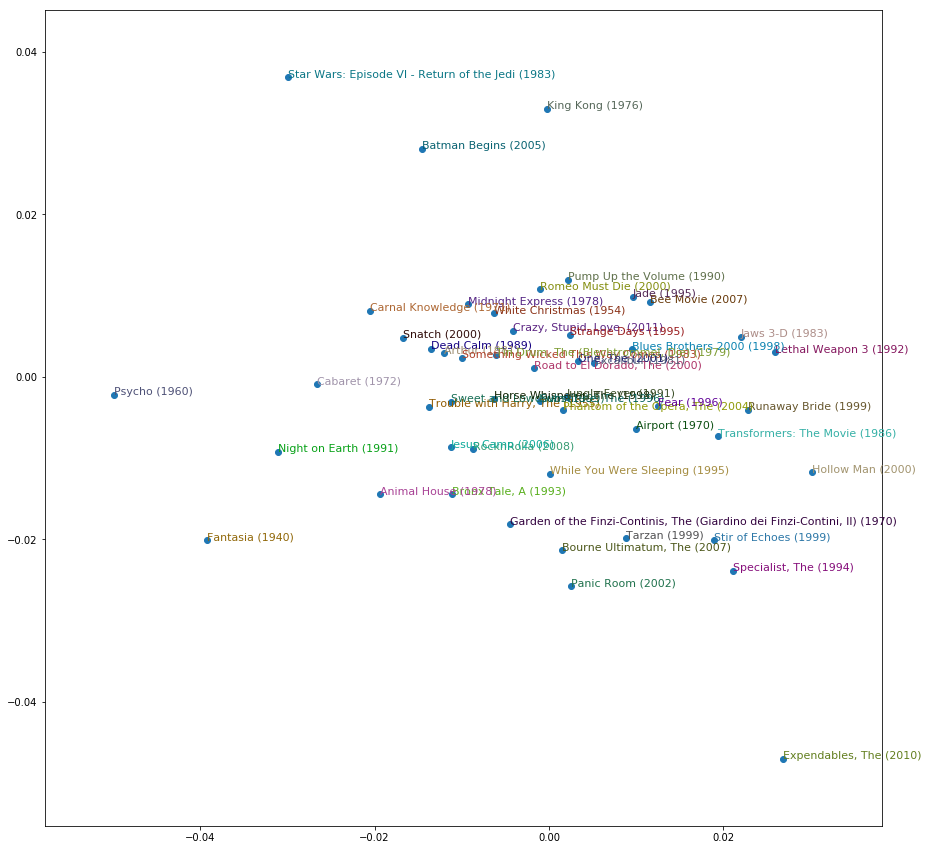

In [103]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

We can also use PCA to dimension reduce and cluster the movie values themselves instead of looking at principal components.

In [104]:
pca2 = PCA(n_components=2)
movie_cluster = pca2.fit_transform(movie_emb)
movie_cluster.shape

(3000, 2)

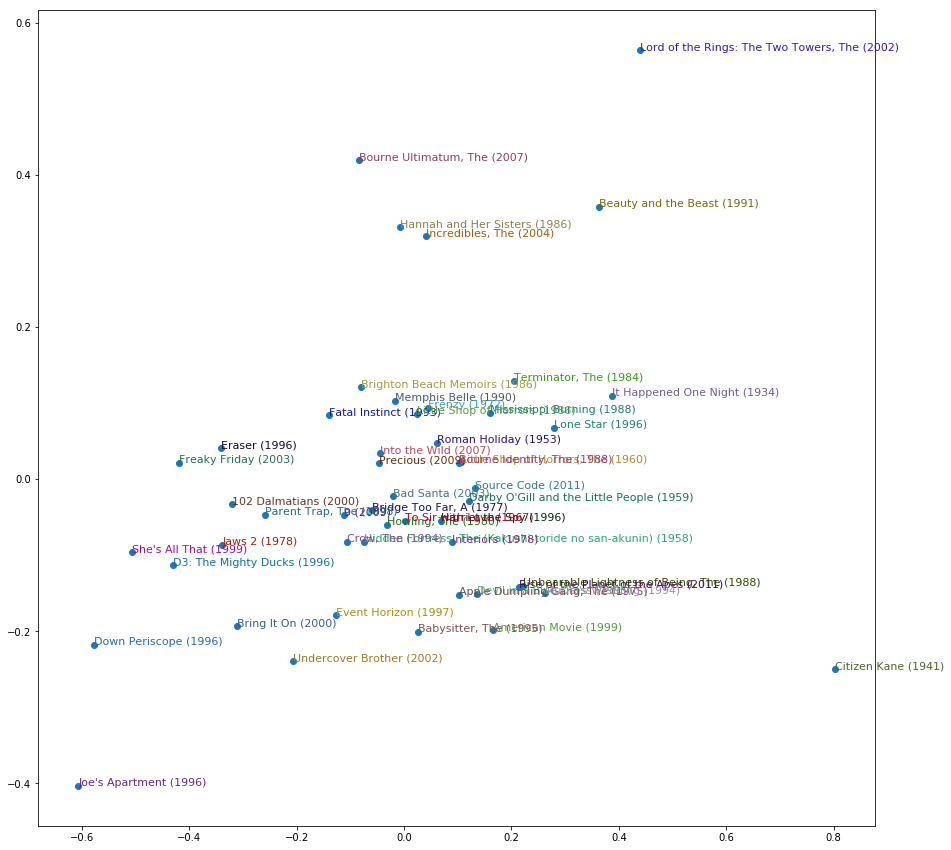

In [106]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = movie_cluster.T[0][idxs]
Y = movie_cluster.T[1][idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# 7. User Recommendations

Now we want to build a recommendation system that can recommend new movies for users to watch. Now that we have the trained model, this is fairly straightforward. We grab the index value for the user and the index values for all the movies that the user has not yet rated, and use these as inputs into the model.

The model will output an array of predicted user ratings for each movie. We will grab the top 10 predictions and output them as recommendations. We'll also write a quick function to get the user's favorite movies so we can compare.

In [107]:
def get_recs(ratings, movies, usr_id, cf, learner):
    new_movies = ratings[~(ratings.userId == usr_id)].movieId.unique()
    
    urs_idx = cf.user2idx[usr_id]
    movie_idx = np.array([cf.item2idx[x] for x in new_movies])
    
    usr = V(torch.LongTensor([int(urs_idx)]))
    movs = V(torch.LongTensor([list(movie_idx)]))
    
    preds = learner.model(usr[0], movs[0])
    top_preds = np.argsort(to_np(-preds))[:10]
    
    top_ids = [[i for i in cf.item2idx.keys() if cf.item2idx[i] == j][0] for j in top_preds]
    recs = movies[movies.movieId.isin(top_ids)].copy()
    
    avg_ratings = ratings.groupby(['movieId'])['rating'].mean()
    top_avg = avg_ratings[avg_ratings.index.isin(recs.movieId.values)]
    
    recs['avg'] = top_avg.values
    recs['predicted'] = to_np(preds[top_preds])
    
    reps = ratings.movieId.value_counts()
    recs['representation'] = reps[reps.index.isin(recs.movieId.values)].values
    
    return recs


In [108]:
def get_favorites(ratings, movies, usr_id):
    fav_movies = ratings[ratings.userId == usr_id][ratings.rating == 5]
    movie_names = movies.set_index('movieId')['title'].to_dict()
    fav_movies['Names'] = fav_movies.movieId.map(lambda x: movie_names[x])
    movie_idx = fav_movies.movieId.apply(lambda x: cf.item2idx[x])
    fav_movies['Bias'] = movie_idx.map(lambda x: to_np(learner.model.ib.weight.data)[x])
    
    return fav_movies

Lets start with user 15. This user has rating a lot of movies. 1700 in fact.

In [109]:
user_id = 15
movie_id = ratings[ratings.userId == user_id].movieId
len(movie_id)

1700

Lets look at 15's favorite movies. 15 has rated 92 movies as 5 stars.

We can see that all these movies are conventionally accepted as good. They all have high bias terms.

In [110]:
fav_15 = get_favorites(ratings, movies, 15)
fav_15.shape

c:\users\gateway\anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(92, 6)

In [111]:
fav_15.head(20)

,userId,movieId,rating,timestamp,Names,Bias
980,15,47,5.0,1054449816,Seven (a.k.a. Se7en) (1995),[0.5770935]
981,15,50,5.0,997938500,"Usual Suspects, The (1995)",[0.8813979]
985,15,82,5.0,1044220302,Antonia's Line (Antonia) (1995),[0.21598637]
992,15,111,5.0,997938500,Taxi Driver (1976),[0.68414515]
997,15,149,5.0,1075142933,Amateur (1994),[0.22726314]
1028,15,246,5.0,997938656,Hoop Dreams (1994),[0.58397615]
1032,15,260,5.0,997938437,Star Wars: Episode IV - A New Hope (1977),[0.78374004]
1036,15,293,5.0,997938567,Léon: The Professional (a.k.a. The Professiona...,[0.621534]
1037,15,296,5.0,997938771,Pulp Fiction (1994),[0.8220524]
1039,15,306,5.0,997938737,Three Colors: Red (Trois couleurs: Rouge) (1994),[0.5625775]


What are some new movies 15 should watch?

In [112]:
recs_15 = get_recs(ratings, movies, 15, cf, learner)
recs_15

,movieId,title,genres,avg,predicted,representation
101,111,Taxi Driver (1976),Crime|Drama|Thriller,4.224576,4.799713,118
724,903,Vertigo (1958),Drama|Mystery|Romance|Thriller,4.224638,4.798220,85
744,923,Citizen Kane (1941),Drama|Mystery,4.200000,4.797861,69
959,1202,Withnail & I (1987),Comedy,3.642857,4.769397,13
1742,2191,"Merry War, A (1997)",Comedy,0.500000,4.716189,7
4001,5214,"Oh, God! (1977)",Comedy|Fantasy,3.750000,4.692409,4
4476,6123,Sunless (Sans Soleil) (1983),Documentary,4.000000,4.688776,4
4849,6867,"Station Agent, The (2003)",Comedy|Drama,3.576923,4.685207,2
6187,34334,Stealth (2005),Action|Adventure|Sci-Fi|Thriller,2.125000,4.678000,1
7280,70121,'Neath the Arizona Skies (1934),Western,0.500000,4.673854,1


Along with the recommendations I had the function also display some useful information for qualifying the recommendations. We can see the average user rating, the predicted rating for 15, and the representation of each movie in the data.

One thing that's concerning is the last 6 recommendations are represented less than 10 times in the data set, which makes me think the weights might not be well tuned.

Some of the recommendations seem good. Others seem off. I don't think Stealth or 'Neath the Arizona Skies would be good recommendations for 15.

Lets grab some other users at random

In [113]:
fav_547 = get_favorites(ratings, movies, 547)
fav_547.head(10)

c:\users\gateway\anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,userId,movieId,rating,timestamp,Names,Bias
78439,547,17,5.0,974778941,Sense and Sensibility (1995),[0.42604464]
78452,547,111,5.0,974809870,Taxi Driver (1976),[0.68414515]
78455,547,125,5.0,1370674374,Flirting With Disaster (1996),[0.063491076]
78466,547,176,5.0,974780806,Living in Oblivion (1995),[0.27757192]
78470,547,194,5.0,986695368,Smoke (1995),[0.5653919]
78479,547,246,5.0,974779093,Hoop Dreams (1994),[0.58397615]
78490,547,296,5.0,981314122,Pulp Fiction (1994),[0.8220524]
78494,547,318,5.0,1149387505,"Shawshank Redemption, The (1994)",[1.1845863]
78521,547,448,5.0,981314419,Fearless (1993),[0.13615397]
78541,547,527,5.0,974809897,Schindler's List (1993),[0.8391947]


In [114]:
rec_547 = get_recs(ratings, movies, 547, cf, learner)
rec_547

,movieId,title,genres,avg,predicted,representation
695,858,"Godfather, The (1972)",Crime|Drama,4.487500,4.812822,200
719,898,"Philadelphia Story, The (1940)",Comedy|Drama|Romance,4.351351,4.777989,165
733,912,Casablanca (1942),Drama|Romance,4.235043,4.770819,151
840,1036,Die Hard (1988),Action|Crime|Thriller,3.864238,4.769384,117
947,1189,"Thin Blue Line, The (1988)",Documentary,4.000000,4.764803,37
973,1217,Ran (1985),Drama|War,4.423077,4.754501,26
1019,1265,Groundhog Day (1993),Comedy|Fantasy|Romance,3.839394,4.740669,21
1092,1348,"Nosferatu (Nosferatu, eine Symphonie des Graue...",Horror,3.809524,4.736687,20
2976,3724,Coming Home (1978),Drama|War,4.115385,4.736194,13
4156,5475,Z (1969),Drama|Mystery|Thriller,4.500000,4.724061,3


In [115]:
fav_380 = get_favorites(ratings, movies, 380)
fav_380.head(10)

c:\users\gateway\anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,userId,movieId,rating,timestamp,Names,Bias
51153,380,32,5.0,1038621928,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),[0.5161124]
51157,380,47,5.0,1038621751,Seven (a.k.a. Se7en) (1995),[0.5770935]
51158,380,50,5.0,1022553465,"Usual Suspects, The (1995)",[0.8813979]
51161,380,110,5.0,949368612,Braveheart (1995),[0.60512805]
51169,380,223,5.0,949367653,Clerks (1994),[0.33354992]
51175,380,296,5.0,949369345,Pulp Fiction (1994),[0.8220524]
51186,380,356,5.0,949367498,Forrest Gump (1994),[0.7892566]
51207,380,593,5.0,949371458,"Silence of the Lambs, The (1991)",[0.8238297]
51228,380,924,5.0,950073539,2001: A Space Odyssey (1968),[0.37957597]
51239,380,1090,5.0,994728493,Platoon (1986),[0.43841362]


In [116]:
rec_380 = get_recs(ratings, movies, 380, cf, learner)
rec_380

,movieId,title,genres,avg,predicted,representation
45,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,4.034826,4.602655,324
48,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.370647,4.540661,311
232,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.221649,4.516809,291
266,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.256173,4.504901,224
284,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.487138,4.502672,220
535,608,Fargo (1996),Comedy|Crime|Drama|Thriller,4.256696,4.485014,202
695,858,"Godfather, The (1972)",Crime|Drama,4.487500,4.468265,201
955,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.193182,4.460089,201
2374,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.178218,4.436952,200
2860,3578,Gladiator (2000),Action|Adventure|Drama,3.965839,4.427437,161


Most of the recommendations make sense. As with the case of user 15, some seem to be pretty out there. I'm sure the model could improve with more data to fill in the representation gaps.

# 8. New User Onboarding

What happens when we get a new user? We need to develop their user weights to onboard them onto the recommendation system. To do this, I'm assuming we have 5 data points for the user to go on (imagine some kind of onboarding survey). In the case where you have a totally new user with no data, the best you could do would be to create a generic new user model and wait for the user to give you some kind of feedback. 

To train the new user weights, we will use the same model with a slight variation. The new model will take movie weights from the main model as an input and only train the weights for the user.

In [117]:
class EmbeddingDotBiasOnboard(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score, i_w, ib_w):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        self.i = i_w
        self.ib = ib_w
        (self.u, self.ub) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_users,1)
        ]]

    def forward(self, users, items):
        um = self.u(users)* self.i(items)
        res = um.sum(1) + self.ub(users).squeeze() + self.ib(items).squeeze()
        res = F.sigmoid(res) * (self.max_score-self.min_score) + self.min_score
        return res

Here we make 5 data points for two new random users. Two extra data points - (1,1,1), (1,1,2) - are added as a dummy validation set. This is because the dataloader expects some validation values to chew on. These don't impact training.

In [118]:
new_userId = pd.Series(np.array([1,1,1,1,1,2,2,2,2,2,1,2]))
new_movieId = pd.Series(np.array([1029, 1061, 1129, 1287, 1339, 3, 141, 344, 356, 364,1,1]))
new_rating = pd.Series(np.array([4.5, 4, 1.5, 2, 5, 4, 4, 2, 3, 3,1,1]))

In [119]:
new_user_df = pd.concat([new_userId, new_movieId, new_rating], axis=1)

In [120]:
new_user_df.columns = ['userId', 'movieId', 'rating']

In [121]:
new_user_df

,userId,movieId,rating
0,1,1029,4.5
1,1,1061,4.0
2,1,1129,1.5
3,1,1287,2.0
4,1,1339,5.0
5,2,3,4.0
6,2,141,4.0
7,2,344,2.0
8,2,356,3.0
9,2,364,3.0


In [122]:
val_idx_o = list(new_user_df.index[-2:])

Here we make a new CollabFilterDataset object. The trick here is we need to pass in the same item index mapping dictionary as the original dataloader to make sure the embedding matrix is used the same way. If we didn't do this, the new dataloader would map movie Ids to a different set of numbers and the model wouldn't work properly.

In [123]:
cf3 = CollabFilterDataset.from_data_frame(path, new_user_df, 'userId', 'movieId', 'rating')

In [124]:
cf3.item2idx = cf.item2idx

Grab the item weights and biases from the original model

In [125]:
learner.model

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

In [126]:
i_w = learner.model.i
ib_w = learner.model.ib

In [127]:
n_users_o = cf3.n_users

In [128]:
model2 = EmbeddingDotBiasOnboard(n_factors, n_users_o, n_items, min_rating, max_rating,
                                i_w, ib_w).cuda()

In [129]:
learner2 = CollabFilterLearner(cf3.get_data(val_idx_o, 128), CollabFilterModel(model2), opt_fn=optim.Adam)

In [130]:
learner2.fit(1e-2, 3, wds=wd, cycle_len=1)

epoch      trn_loss   val_loss                                                                                         
    0      1.223434   2.639514  
    1      1.222957   2.639514                                                                                         
    2      1.222799   2.659169                                                                                         



[2.6591691970825195]

Now we can start getting recommendations for the new users!

In [131]:
def get_recs2(ratings, new_user_df, movies, usr_id, cf, learner):
    new_movies = ratings[~ratings.movieId.isin(new_user_df.movieId.values)].movieId.unique()
    
    urs_idx = cf.user2idx[usr_id]
    movie_idx = np.array([cf.item2idx[x] for x in new_movies])
    
    usr = V(torch.LongTensor([int(urs_idx)]))
    movs = V(torch.LongTensor([list(movie_idx)]))
    
    preds = learner.model(usr[0], movs[0])
    top_preds = np.argsort(to_np(-preds))[:10]
    
    top_ids = [[i for i in cf.item2idx.keys() if cf.item2idx[i] == j][0] for j in top_preds]
    recs = movies[movies.movieId.isin(top_ids)].copy()
    
    avg_ratings = ratings.groupby(['movieId'])['rating'].mean()
    top_avg = avg_ratings[avg_ratings.index.isin(recs.movieId.values)]
    
    recs['avg'] = top_avg.values
    recs['predicted'] = to_np(preds[top_preds])
    
    reps = ratings.movieId.value_counts()
    recs['representation'] = reps[reps.index.isin(recs.movieId.values)].values
    
    return recs

In [132]:
user_1_recs = get_recs2(ratings, new_user_df, movies, 1, cf3, learner2)
user_1_recs

,movieId,title,genres,avg,predicted,representation
237,265,Like Water for Chocolate (Como agua para choco...,Drama|Fantasy|Romance,3.879032,3.972521,304
384,435,Coneheads (1993),Comedy|Sci-Fi,2.463636,3.787145,274
427,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.706204,3.719348,72
518,585,"Brady Bunch Movie, The (1995)",Comedy,3.073171,3.693156,62
525,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.138158,3.676779,62
658,802,Phenomenon (1996),Drama|Romance,3.326389,3.654846,55
915,1147,When We Were Kings (1996),Documentary,4.437500,3.638177,41
2925,3671,Blazing Saddles (1974),Comedy|Western,3.935484,3.631891,26
3208,4006,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi,3.500000,3.629923,16
5583,8873,"Motorcycle Diaries, The (Diarios de motociclet...",Adventure|Drama,3.673077,3.625023,9


In [133]:
user_2_recs = get_recs2(ratings, new_user_df, movies, 2, cf3, learner2)
user_2_recs

,movieId,title,genres,avg,predicted,representation
237,265,Like Water for Chocolate (Como agua para choco...,Drama|Fantasy|Romance,3.879032,3.948054,304
384,435,Coneheads (1993),Comedy|Sci-Fi,2.463636,3.816398,274
427,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.706204,3.669780,72
518,585,"Brady Bunch Movie, The (1995)",Comedy,3.073171,3.667745,62
525,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.138158,3.664684,62
658,802,Phenomenon (1996),Drama|Romance,3.326389,3.632204,55
915,1147,When We Were Kings (1996),Documentary,4.437500,3.628390,41
2925,3671,Blazing Saddles (1974),Comedy|Western,3.935484,3.623064,26
3208,4006,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi,3.500000,3.604172,16
5583,8873,"Motorcycle Diaries, The (Diarios de motociclet...",Adventure|Drama,3.673077,3.599544,9


Or to write it as a function that returns recs and the weights to be incorporated with the original model

In [134]:
def onboarding(new_user_df, cf, path, learner, wd):
    
    cf_o = CollabFilterDataset.from_data_frame(path, new_user_df, 'userId', 'movieId', 'rating')
    cf_o.item2idx = cf.item2idx
    
    i_w = learner.model.i
    ib_w = learner.model.ib
    
    n_factors = i_w.weight.data.shape[1]
    
    n_items = cf.n_items
    min_rating = cf.min_score
    max_rating = cf.max_score
    
    n_users_o = cf_o.n_users
    val_idx_o = list(new_user_df.index[-n_users_o:])
    
    model_o = EmbeddingDotBiasOnboard(n_factors, n_users_o, n_items, min_rating, max_rating,
                                i_w, ib_w).cuda()
    
    learner_o = CollabFilterLearner(cf_o.get_data(val_idx_o, 128), CollabFilterModel(model_o), opt_fn=optim.Adam)
    
    learner_o.fit(1e-2, 3, wds=wd, cycle_len=1)
    
    rec_lst = []
    new_weights = [learner_o.model.u, learner_o.model.ub]
    
    for usr in range(n_users_o):
        usr_id = usr+1
        print(usr_id)
        recs = get_recs2(ratings, new_user_df, movies, usr_id, cf_o, learner_o)
        rec_lst.append(recs)
    
    return rec_lst, new_weights

In [135]:
onboard_recs, onboard_weight = onboarding(new_user_df, cf, path, learner, wd)

epoch      trn_loss   val_loss                                                                                         
    0      1.230649   2.759184  
    1      1.230193   2.759184                                                                                         
    2      1.230041   2.789599                                                                                         

1
2


In [136]:
onboard_recs[0]

,movieId,title,genres,avg,predicted,representation
237,265,Like Water for Chocolate (Como agua para choco...,Drama|Fantasy|Romance,3.879032,3.962680,304
384,435,Coneheads (1993),Comedy|Sci-Fi,2.463636,3.798850,274
427,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.706204,3.710291,72
518,585,"Brady Bunch Movie, The (1995)",Comedy,3.073171,3.707555,62
525,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.138158,3.656945,62
658,802,Phenomenon (1996),Drama|Romance,3.326389,3.646285,55
915,1147,When We Were Kings (1996),Documentary,4.437500,3.635476,41
2925,3671,Blazing Saddles (1974),Comedy|Western,3.935484,3.631083,26
3208,4006,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi,3.500000,3.623026,16
5583,8873,"Motorcycle Diaries, The (Diarios de motociclet...",Adventure|Drama,3.673077,3.622411,9


In [137]:
onboard_recs[1]

,movieId,title,genres,avg,predicted,representation
237,265,Like Water for Chocolate (Como agua para choco...,Drama|Fantasy|Romance,3.879032,3.908703,304
384,435,Coneheads (1993),Comedy|Sci-Fi,2.463636,3.765860,274
427,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.706204,3.674380,62
518,585,"Brady Bunch Movie, The (1995)",Comedy,3.073171,3.670539,62
525,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.138158,3.648418,55
915,1147,When We Were Kings (1996),Documentary,4.437500,3.634481,41
2010,2513,Pet Sematary (1989),Horror,3.027778,3.632418,26
2925,3671,Blazing Saddles (1974),Comedy|Western,3.935484,3.586284,18
3208,4006,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi,3.500000,3.583924,16
5583,8873,"Motorcycle Diaries, The (Diarios de motociclet...",Adventure|Drama,3.673077,3.577738,9


In [138]:
onboard_weight

[Embedding(2, 50), Embedding(2, 1)]

# 9. Generic User Model

To deal with the case where we have no data to go on for a new user, we need a generic model that can be applied in the absence of any data to go on for the user. To do this, we will create a generic user model based on the average rating for the 3000 most reviewed movies.

In [139]:
top_movie_ratings = ratings[ratings.movieId.isin(topMovies)]

In [140]:
avg_ratings = top_movie_ratings.groupby(['movieId']).rating.mean()

In [141]:
generic_user_df = pd.DataFrame(pd.Series(avg_ratings.values))
generic_user_df.columns = ['rating']
generic_user_df['movieId'] = avg_ratings.values
generic_user_df['userId'] = 1

In [142]:
generic_recs, generic_weights = onboarding(generic_user_df, cf, path, learner, wd)

epoch      trn_loss   val_loss                                                                                         
    0      0.413491   0.087875  
    1      0.255796   0.102705                                                                                         
    2      0.151943   0.012418                                                                                         

1


Here's what a new user gets when they don't fill out the survey:

In [143]:
generic_recs[0]

,movieId,title,genres,avg,predicted,representation
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,3.923469,4.431568,215
137,158,Casper (1995),Adventure|Children,2.870690,4.374500,196
521,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,3.674419,4.312845,138
961,1204,Lawrence of Arabia (1962),Adventure|Drama|War,4.215686,4.297038,70
1113,1373,Star Trek V: The Final Frontier (1989),Action|Sci-Fi,2.780000,4.290407,58
1132,1394,Raising Arizona (1987),Comedy,3.950000,4.279908,51
1859,2348,Sid and Nancy (1986),Drama,3.454545,4.272264,30
2103,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,3.199275,4.272120,26
3220,4019,Finding Forrester (2000),Drama,3.423077,4.242513,25
4034,5266,Panic Room (2002),Thriller,3.216667,4.230623,11


# 10. Conclusions

This was a fun project to work on. I liked moving beyond just training a model to applying the model to different tasks. The project was also a good excuse to brush up on some linear algebra.